In [1]:
# %cd ~/PycharmProjects/muse
%cd /iliad/u/belkhale/muse
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np


def sweep_from_arr(arr):
    s = "[[[ "
    for a in arr:
        s = s + str(a) + " "
    s = s + "]]]"
    return s


/iliad/u/belkhale/muse


In [13]:
# show the state diversity needed?

def plot_2d_state_heatmap(data, t1=None, t2=None, xy_key='robot0_eef_pos', done_key='done', n_bins=30, vmax=200, num_rollouts=None, log=True, ax=None):
    xy = data[xy_key]

    splits = data[done_key].nonzero()[0][:-1] + 1
    episodes = np.split(xy, splits, axis=0)
    if num_rollouts is not None:
        episodes = episodes[:num_rollouts]

    if t1 is not None:
        if t2 is None:
            episodes = [ep[t1:] for ep in episodes]
        else:
            episodes = [ep[t1:t2] for ep in episodes]

    partial_xy = np.concatenate(episodes)
    x, y = partial_xy[..., 0], partial_xy[..., 1]
    
    if log:
#         norm = colors.LogNorm(vmin=1, vmax=vmax+1)
        norm = colors.FuncNorm((lambda v: np.log(v + 1) / np.log(vmax + 1), lambda v: np.exp(v*np.log(vmax+1))),
                               vmin=0, vmax=vmax)
    else:
        norm = None
    
    if ax is not None:
        return ax.hist2d(x, y, bins=(n_bins, n_bins), cmap=plt.cm.jet, 
                           norm=norm)[-1]
    else:
        plt.hist2d(x, y, bins=(n_bins, n_bins), cmap=plt.cm.jet, 
                           norm=norm)
        plt.colorbar()
        plt.show()

Loading human_square_30k.npz


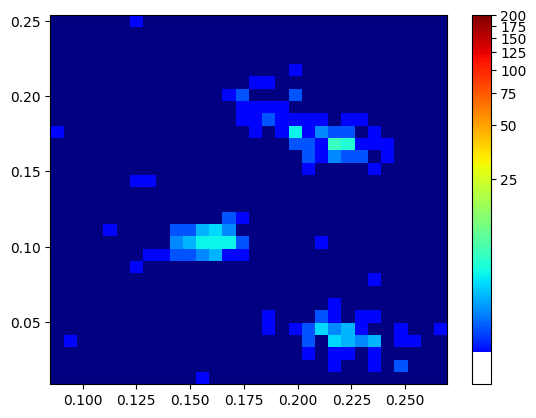

In [14]:
name = 'human_square_30k.npz'
file = f'data/hvs/{name}'
print("Loading", name)
plot_2d_state_heatmap(dict(np.load(file, allow_pickle=True)), t1=-1)

# LEARNED

In [16]:
def compute_success_rate(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    if max_steps is not None:
        # only look at max reward over first "max_steps" steps
        rew_chunks = [r[:max_steps] for r in rew_chunks]
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_return = np.array([np.max(rews) for rews in rew_chunks])
    return np.mean(each_return)
    
def compute_traj_len(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_len = np.array([len(rews) for rews in rew_chunks])
    return np.mean(each_len)

def compute_traj_std(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_len = np.array([len(rews) for rews in rew_chunks])
    return np.std(each_len)
    

In [22]:
# extract success rates for each set of rollouts
import os
from configs.utils import hr_name

def print_metric(noise_type='s', prefix="best_", num_rollouts=100, dset_override=None, metric_fn=compute_success_rate):

    s_noises = [0.05, 0.1, 0.2]
    typed_noises = {
        'h': [0],  # human has no noise
        'p': [0, 0.005, 0.01, 0.02],
        's': s_noises,
    }[noise_type]

    dset_suffs = ['', '-first100', '-first50']
    if dset_override is not None:
        dset_suffs = [dset_override]
    
    batch_sizes = [256 for _ in dset_suffs]

    for batch_size, suff in zip(batch_sizes, dset_suffs):
        success = np.empty((len(typed_noises), len(s_noises)), dtype=np.float32)
        for i, n in enumerate(typed_noises):
            hr_s_sweep = sweep_from_arr(s_noises)
            # special case for zero noise
            if n == 0:
                noise = ""
            else:
                noise = f"_l{noise_type}n{hr_name(n)}"

            save_names = [f"{prefix}eval{num_rollouts}_lsn{hr_name(inner_s)}.npz" for inner_s in s_noises]
            hr_names = sweep_from_arr(save_names)

            # single dataset overrides the list of suffixes.
            if dset_override is not None:
                dset = suff
            else:
                assert noise_type != 'h', "Human dataset requires dset override!"
            dset = f"scripted_rm{noise}_square_200ep{suff}"

            exp_name = f'experiments/hvs/velact_b{batch_size}_h10_{dset}_bc-l2_mlp400-d2'
            for j, file in enumerate(save_names):
                path = f"{exp_name}/{file}"
                assert os.path.exists(path), path
                success[i, j] = metric_fn(path, num_rollouts)

        print(f"Suff='{suff}'...")
        print(success)
        print('------------------------------')


In [23]:
print('SYSTEM NOISE')
print_metric(noise_type='s', prefix='best_')
print('\nPOLICY NOISE')
print_metric(noise_type='p', prefix='best_')

SYSTEM NOISE
Suff=''...
[[0.61 0.59 0.31]
 [0.76 0.82 0.73]
 [0.62 0.7  0.85]]
------------------------------
Suff='-first100'...
[[0.73 0.62 0.45]
 [0.73 0.79 0.62]
 [0.73 0.84 0.79]]
------------------------------
Suff='-first50'...
[[0.63 0.58 0.31]
 [0.65 0.69 0.73]
 [0.55 0.79 0.87]]
------------------------------

POLICY NOISE
Suff=''...
[[0.3  0.29 0.07]
 [0.65 0.64 0.31]
 [0.87 0.81 0.52]
 [0.8  0.81 0.8 ]]
------------------------------
Suff='-first100'...
[[0.26 0.23 0.09]
 [0.79 0.65 0.4 ]
 [0.93 0.94 0.76]
 [0.61 0.59 0.47]]
------------------------------
Suff='-first50'...
[[0.19 0.17 0.09]
 [0.69 0.6  0.32]
 [0.85 0.9  0.8 ]
 [0.66 0.78 0.83]]
------------------------------


In [27]:
# success rate for scripted policy, policy noise datasets (100 step max)
fs = [
    'scripted_rm_lsn0_05_square_200ep.npz',
    'scripted_rm_lsn0_1_square_200ep.npz',
    'scripted_rm_lsn0_2_square_200ep.npz',
    'scripted_rm_square_200ep.npz',
    'scripted_rm_lpn0_005_square_200ep.npz',
    'scripted_rm_lpn0_01_square_200ep.npz',
    'scripted_rm_lpn0_02_square_200ep.npz',
]
for f in fs:
    print(f, compute_success_rate(f'data/hvs/{f}', 200))

scripted_rm_lsn0_05_square_200ep.npz 1.0
scripted_rm_lsn0_1_square_200ep.npz 1.0
scripted_rm_lsn0_2_square_200ep.npz 1.0
scripted_rm_square_200ep.npz 1.0
scripted_rm_lpn0_005_square_200ep.npz 1.0
scripted_rm_lpn0_01_square_200ep.npz 1.0
scripted_rm_lpn0_02_square_200ep.npz 1.0


# TRAJECTORY LENGTH

In [30]:
# MEAN
for f in fs[:3]:
    print(f, compute_traj_len(f'data/hvs/{f}', 200))

print('#################')
for f in fs[4:]:
    print(f, compute_traj_len(f'data/hvs/{f}', 200))


scripted_rm_lsn0_05_square_200ep.npz 234.545
scripted_rm_lsn0_1_square_200ep.npz 236.62
scripted_rm_lsn0_2_square_200ep.npz 253.165
#################
scripted_rm_lpn0_005_square_200ep.npz 234.9
scripted_rm_lpn0_01_square_200ep.npz 251.43
scripted_rm_lpn0_02_square_200ep.npz 290.555


In [31]:
# STD
for f in fs[:3]:
    print(f, compute_traj_std(f'data/hvs/{f}', 200))

print('#################')
for f in fs[4:]:
    print(f, compute_traj_std(f'data/hvs/{f}', 200))


scripted_rm_lsn0_05_square_200ep.npz 22.79118195706401
scripted_rm_lsn0_1_square_200ep.npz 24.738746936738732
scripted_rm_lsn0_2_square_200ep.npz 25.70306936924071
#################
scripted_rm_lpn0_005_square_200ep.npz 21.95267637441959
scripted_rm_lpn0_01_square_200ep.npz 28.25004601766164
scripted_rm_lpn0_02_square_200ep.npz 37.41078688025688


# Action Variance

In [3]:
#SQUARE

# some fixed normalization (1/sig^2)
norm_file = 'data/hvs/human_square_30k.npz'
data = np.load(norm_file, allow_pickle=True)
action = data['action']

sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]
dsets = [
    'human_square_30k',
#     'multihuman_square_80k',
    'multihuman-better_square_20k',
    'multihuman-okay_square_25k',
    'multihuman-worse_square_35k',
    'scripted_rm_lsn0_05_square_200ep',
    'scripted_rm_lpn0_005_square_200ep'
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat object --use_state_norm --state_norm_file {norm_file} --action_key action --action_scale {sigma_str} --cluster_eps 0.2
        

2023-05-14 17:36:57.694 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_square_30k.npz
2023-05-14 17:36:57.758 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 17:36:57.759 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (30154, 3)
2023-05-14 17:36:57.760 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (30154, 4)
2023-05-14 17:36:57.761 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (30154, 14)
2023-05-14 17:36:57.762 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (30154, 7)
2023-05-14 17:36:57.762 | DEBUG    | __main__:<module>:89 - Episode Done Na

2023-05-14 17:39:20.114 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/multihuman-okay_square_25k.npz
2023-05-14 17:39:20.168 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 17:39:20.169 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (26456, 3)
2023-05-14 17:39:20.169 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (26456, 4)
2023-05-14 17:39:20.170 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (26456, 14)
2023-05-14 17:39:20.170 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (26456, 7)
2023-05-14 17:39:20.171 | DEBUG    | __main__:<module>:89 - Episo

2023-05-14 17:43:02.736 | DEBUG    | __main__:<module>:210 - -----------------------------------------------------------
2023-05-14 17:43:02.761 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/scripted_rm_lsn0_05_square_200ep.npz
2023-05-14 17:43:02.859 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_eul', 'robot0_eef_quat', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 17:43:02.860 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (46909, 3)
2023-05-14 17:43:02.861 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (46909, 4)
2023-05-14 17:43:02.861 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (46909, 14)
2023-05-14 17:43:02.862 | DEBUG    | __main__

2023-05-14 17:51:20.234 | DEBUG    | __main__:<module>:200 - Var[4] = 7.008959977048402e-06
2023-05-14 17:51:20.235 | DEBUG    | __main__:<module>:200 - Var[5] = 0.001745230542649571
2023-05-14 17:51:20.237 | DEBUG    | __main__:<module>:200 - Var[6] = 0.06828586404489811
2023-05-14 17:51:20.238 | DEBUG    | __main__:<module>:201 - Total Var = 0.08987398330176452
2023-05-14 17:51:20.238 | DEBUG    | __main__:<module>:202 - Total Weighted Var = 0.2547949420509778
2023-05-14 17:51:20.240 | DEBUG    | __main__:<module>:204 - Bin size, avg=41.19965942954449, med=10.0, range=[1, 700]
2023-05-14 17:51:20.242 | DEBUG    | __main__:<module>:207 - Normalized bin size, avg=0.0008769616736812364, med=0.00021285653469561516, range=[2.1285653469561517e-05, 0.01489995742869306]
2023-05-14 17:51:20.245 | DEBUG    | __main__:<module>:210 - -----------------------------------------------------------


2023-05-14 12:29:00.145 | DEBUG    | __main__:<module>:61 - File Path: data/hvs/scripted_rm_lsn0_05_square_200ep.npz
2023-05-14 12:29:00.250 | DEBUG    | __main__:<module>:70 - ['object', 'robot0_eef_pos', 'robot0_eef_eul', 'robot0_eef_quat', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 12:29:00.250 | DEBUG    | __main__:<module>:86 - Key Name: robot0_eef_pos, raw shape: (46909, 3)
2023-05-14 12:29:00.251 | DEBUG    | __main__:<module>:86 - Key Name: robot0_eef_quat, raw shape: (46909, 4)
2023-05-14 12:29:00.251 | DEBUG    | __main__:<module>:86 - Key Name: object, raw shape: (46909, 14)
2023-05-14 12:29:00.252 | DEBUG    | __main__:<module>:87 - Action Key Name: action, raw shape: (46909, 7)
2023-05-14 12:29:00.252 | DEBUG    | __main__:<module>:88 -

2023-05-14 12:37:03.786 | DEBUG    | __main__:<module>:178 - Var[6] = 0.01711128671273348
2023-05-14 12:37:03.787 | DEBUG    | __main__:<module>:179 - Total Var = 0.020047835871416324
2023-05-14 12:37:03.787 | DEBUG    | __main__:<module>:180 - Total Weighted Var = 0.062002325107673145
2023-05-14 12:37:03.789 | DEBUG    | __main__:<module>:182 - Bin size, avg=2.0489995742869307, med=1.0, range=[1, 58]
2023-05-14 12:37:03.797 | DEBUG    | __main__:<module>:185 - Normalized bin size, avg=4.3614294897550674e-05, med=2.1285653469561517e-05, range=[2.1285653469561517e-05, 0.0012345679012345679]
2023-05-14 12:37:03.798 | DEBUG    | __main__:<module>:188 - -----------------------------------------------------------


In [2]:
# some fixed normalization (1/sig^2)
action = np.load('data/hvs/human_can_25k.npz', allow_pickle=True)['action']
sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]

# CAN
dsets = [
    'human_can_25k',
    'multihuman-better_can_15k',
    'multihuman-okay_can_20k',
    'multihuman-worse_can_30k',
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat object --use_state_norm --action_scale {sigma_str} --action_key action --cluster_eps 0.2
        

2023-05-14 17:33:12.158 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_can_25k.npz
2023-05-14 17:33:12.215 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 17:33:12.216 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (23207, 3)
2023-05-14 17:33:12.216 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (23207, 4)
2023-05-14 17:33:12.218 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (23207, 14)
2023-05-14 17:33:12.219 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (23207, 7)
2023-05-14 17:33:12.220 | DEBUG    | __main__:<module>:89 - Episode Done Name:

2023-05-14 17:34:34.496 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (18053, 3)
2023-05-14 17:34:34.496 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (18053, 4)
2023-05-14 17:34:34.497 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (18053, 14)
2023-05-14 17:34:34.497 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (18053, 7)
2023-05-14 17:34:34.498 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 17:34:34.505 | DEBUG    | __main__:<module>:123 - New Data shape: (18053, 21)
2023-05-14 17:34:34.506 | DEBUG    | __main__:<module>:124 - New Action shape: (18053, 7)
2023-05-14 17:34:34.510 | DEBUG    | __main__:<module>:134 - Using normalized state data: 
mu=[ 0.09393011 -0.092972    0.9687039   0.98052025 -0.01076507  0.01754672
 -0.02118039  0.11129861 -0.11440343  0.910844    0.00977481 -0.01723072
  0.6113461   0.17010272  0.01455457  0.02297751  0.05893321  0.05571983

In [5]:
# FIXED OBS NORM

# some fixed normalization (1/sig^2)
norm_file = 'data/hvs/human_can_25k.npz'
action = np.load(norm_file, allow_pickle=True)['action']
sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]

# CAN
dsets = [
    'human_can_25k',
    'multihuman-better_can_15k',
    'multihuman-okay_can_20k',
    'multihuman-worse_can_30k',
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat object --use_state_norm --state_norm_file {norm_file} --action_scale {sigma_str} --action_key action --cluster_eps 0.2
        

2023-05-14 17:19:21.088 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_can_25k.npz
2023-05-14 17:19:21.139 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 17:19:21.139 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (23207, 3)
2023-05-14 17:19:21.140 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (23207, 4)
2023-05-14 17:19:21.141 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (23207, 14)
2023-05-14 17:19:21.141 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (23207, 7)
2023-05-14 17:19:21.142 | DEBUG    | __main__:<module>:89 - Episode Done Name:

2023-05-14 17:20:45.650 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (18053, 3)
2023-05-14 17:20:45.651 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (18053, 4)
2023-05-14 17:20:45.651 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (18053, 14)
2023-05-14 17:20:45.652 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (18053, 7)
2023-05-14 17:20:45.652 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 17:20:45.660 | DEBUG    | __main__:<module>:123 - New Data shape: (18053, 21)
2023-05-14 17:20:45.660 | DEBUG    | __main__:<module>:124 - New Action shape: (18053, 7)
2023-05-14 17:20:45.661 | DEBUG    | __main__:<module>:129 - Loading data/hvs/human_can_25k.npz for normalizing states...
2023-05-14 17:20:45.680 | DEBUG    | __main__:<module>:134 - Using normalized state data: 
mu=[ 0.10789825 -0.07529953  0.9834947   0.9626342  -0.01928422  0.0055165
 -0.05819027  0.12079547

# action variance POSE only

In [4]:
#SQUARE pose only

# some fixed normalization (1/sig^2)
norm_file = 'data/hvs/human_square_30k.npz'
data = np.load(norm_file, allow_pickle=True)
action = data['action']

sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]
dsets = [
    'human_square_30k',
#     'multihuman_square_80k',
    'multihuman-better_square_20k',
    'multihuman-okay_square_25k',
    'multihuman-worse_square_35k',
    'scripted_rm_lsn0_05_square_200ep',
    'scripted_rm_lpn0_005_square_200ep'
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat --use_state_norm --state_norm_file {norm_file} --action_key action --action_scale {sigma_str} --cluster_eps 0.05
        

2023-05-14 18:15:03.600 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_square_30k.npz
2023-05-14 18:15:03.660 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 18:15:03.660 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (30154, 3)
2023-05-14 18:15:03.661 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (30154, 4)
2023-05-14 18:15:03.661 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (30154, 7)
2023-05-14 18:15:03.662 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 18:15:03.671 | DEBUG    | __main__:<module>:123 - New Data shape: (30154, 7)
2023

2023-05-14 18:16:14.298 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 18:16:14.305 | DEBUG    | __main__:<module>:123 - New Data shape: (26456, 7)
2023-05-14 18:16:14.305 | DEBUG    | __main__:<module>:124 - New Action shape: (26456, 7)
2023-05-14 18:16:14.306 | DEBUG    | __main__:<module>:129 - Loading data/hvs/human_square_30k.npz for normalizing states...
2023-05-14 18:16:14.319 | DEBUG    | __main__:<module>:134 - Using normalized state data: 
mu=[ 0.0221378   0.12769784  0.9233971   0.88738257 -0.00985888  0.02981661
 -0.00627095]
sigma=[0.14880033 0.06730275 0.0598591  0.10894126 0.44433743 0.03811176
 0.02802529]
2023-05-14 18:16:14.321 | DEBUG    | __main__:<module>:145 - Action scale: [ 5.70903864  5.70903864  5.70903864 41.66081198 41.66081198 41.66081198
  1.00296452]
2023-05-14 18:16:14.322 | DEBUG    | __main__:<module>:153 - Chunk 0 -> 5000...
2023-05-14 18:16:21.243 | DEBUG    | __main__:<module>:153 - Chunk 5000 -> 10000...
2023-05-14 18:16:28.

2023-05-14 18:18:08.506 | DEBUG    | __main__:<module>:145 - Action scale: [ 5.70903864  5.70903864  5.70903864 41.66081198 41.66081198 41.66081198
  1.00296452]
2023-05-14 18:18:08.507 | DEBUG    | __main__:<module>:153 - Chunk 0 -> 5000...
2023-05-14 18:18:20.732 | DEBUG    | __main__:<module>:153 - Chunk 5000 -> 10000...
2023-05-14 18:18:32.919 | DEBUG    | __main__:<module>:153 - Chunk 10000 -> 15000...
2023-05-14 18:18:45.121 | DEBUG    | __main__:<module>:153 - Chunk 15000 -> 20000...
2023-05-14 18:18:57.318 | DEBUG    | __main__:<module>:153 - Chunk 20000 -> 25000...
2023-05-14 18:19:09.524 | DEBUG    | __main__:<module>:153 - Chunk 25000 -> 30000...
2023-05-14 18:19:21.608 | DEBUG    | __main__:<module>:153 - Chunk 30000 -> 35000...
2023-05-14 18:19:33.426 | DEBUG    | __main__:<module>:153 - Chunk 35000 -> 40000...
2023-05-14 18:19:45.258 | DEBUG    | __main__:<module>:153 - Chunk 40000 -> 45000...
2023-05-14 18:19:57.039 | DEBUG    | __main__:<module>:153 - Chunk 45000 -> 500

In [5]:
# CAN pose only

# some fixed normalization (1/sig^2)
action = np.load('data/hvs/human_can_25k.npz', allow_pickle=True)['action']
sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]

# CAN
dsets = [
    'human_can_25k',
    'multihuman-better_can_15k',
    'multihuman-okay_can_20k',
    'multihuman-worse_can_30k',
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat --use_state_norm --action_scale {sigma_str} --action_key action --cluster_eps 0.05
    


2023-05-14 18:22:15.722 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_can_25k.npz
2023-05-14 18:22:15.773 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 18:22:15.774 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (23207, 3)
2023-05-14 18:22:15.774 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (23207, 4)
2023-05-14 18:22:15.775 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (23207, 7)
2023-05-14 18:22:15.775 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 18:22:15.784 | DEBUG    | __main__:<module>:123 - New Data shape: (23207, 7)
2023-05

2023-05-14 18:22:58.899 | DEBUG    | __main__:<module>:145 - Action scale: [ 2.39619692  2.39619692  2.39619692 32.91069549 32.91069549 32.91069549
  1.01450331]
2023-05-14 18:22:58.899 | DEBUG    | __main__:<module>:153 - Chunk 0 -> 5000...
2023-05-14 18:23:03.620 | DEBUG    | __main__:<module>:153 - Chunk 5000 -> 10000...
2023-05-14 18:23:08.342 | DEBUG    | __main__:<module>:153 - Chunk 10000 -> 15000...
2023-05-14 18:23:13.066 | DEBUG    | __main__:<module>:153 - Chunk 15000 -> 20000...
2023-05-14 18:23:15.956 | DEBUG    | __main__:<module>:157 - Merging dist mats...
2023-05-14 18:23:17.772 | DEBUG    | __main__:<module>:196 - -----------------------------------------------------------
2023-05-14 18:23:17.773 | DEBUG    | __main__:<module>:198 - Files = ['data/hvs/multihuman-okay_can_20k.npz']
2023-05-14 18:23:17.774 | DEBUG    | __main__:<module>:200 - Var[0] = 0.0008999435815491415
2023-05-14 18:23:17.774 | DEBUG    | __main__:<module>:200 - Var[1] = 0.0010667903602790056
2023-05

# seeds

In [24]:
# extract success rates for each set of rollouts
import os
from configs.utils import hr_name
import subprocess


def sweep_from_arr(arr):
    s = "[[[ "
    for a in arr:
        s = s + str(a) + " "
    s = s + "]]]"
    return s


def print_success(noise_type='s', noise_values=[0.05, 0.1, 0.2], s_noises = [0.05, 0.1, 0.2], prefix="best_", num_rollouts=100, 
                  fn=compute_success_rate, run_cmd=True, run_compute=False, 
                  batch_sizes = [256, 256],
                  dset_suffs = ['', '-first100'], data_seed=''):

    if run_cmd:
        for suff, bs in zip(dset_suffs, batch_sizes):
            for i, s in enumerate(noise_values):
                noise = f"_l{noise_type}n{hr_name(s)}"
                
                assert isinstance(data_seed, str)

                dset = f"scripted{data_seed}_rm{noise}_square_200ep{suff}"
                exp_name = f'experiments/hvs/velact_b{bs}_h10_{dset}_bc-l2_mlp400-d2'
                
                files = [f"{prefix}eval{num_rollouts}_lsn{hr_name(es)}.npz" for es in s_noises]
                sweep_files = sweep_from_arr(files)

                noise_sweep = sweep_from_arr(s_noises)

                command = f"python scripts/slurm.py -sp -c iliad --cpus {2*len(s_noises)} --job-name sqeval{noise}{suff} --- " \
                          f"python scripts/collect.py --max_eps {num_rollouts} --save_file {sweep_files} " \
                          f"--save_every_n_episodes {num_rollouts} --model_file {prefix}model.pt --track_returns exp={exp_name} " \
                          f"%env_train --pos_noise_std {noise_sweep}"
                subprocess.run(command, shell=True)
    if run_compute:
        for suff, bs in zip(dset_suffs, batch_sizes):
            if isinstance(data_seed, str):
                data_seed = [data_seed]
            success = np.empty((len(data_seed), len(noise_values), len(s_noises)), dtype=np.float32)
            for i, s in enumerate(noise_values):

                for l, ds in enumerate(data_seed):
                    noise = f"_l{noise_type}n{hr_name(s)}"
                    dset = f"scripted{ds}_rm{noise}_square_200ep{suff}"
                    exp_name = f'experiments/hvs/velact_b{bs}_h10_{dset}_bc-l2_mlp400-d2'
                
                    for j, es in enumerate(s_noises):
                        file = f"{prefix}eval{num_rollouts}_lsn{hr_name(es)}.npz"

                        path = f"{exp_name}/{file}"
                        assert os.path.exists(path), path
                        success[l, i, j] = fn(path, num_rollouts)

            print(f"suff='{suff}'...")
            print(format_normal_mat_for_latex(success))
            print('------------------------------')

def format_normal_mat_for_latex(success):
    assert len(success.shape) == 3
    
    if success.shape[0] == 1:
        return str(success[0])

    mean = success.mean(0)
    stderr = success.std(0) / np.sqrt(success.shape[0])
    string = ""
    for i in range(success.shape[1]):
        row = ""
        for j in range(success.shape[2]):
            row += "$%.1f(%.1f)$" % (mean[i,j] * 100, stderr[i,j] * 100)
            if j + 1 < success.shape[2]:
                row += " & "
        string += row + "\\\\ \n"
    return string
        


In [12]:
print_success(noise_type='s', data_seed="", run_cmd=True, run_compute=False)

2023-05-13 17:23:10.194 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]h68x492u.sh


Submitted batch job 6093938


2023-05-13 17:23:11.596 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]66gauog0.sh


Submitted batch job 6093939


2023-05-13 17:23:12.998 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]2i63pe4k.sh


Submitted batch job 6093940


2023-05-13 17:23:14.387 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]9hh04r_b.sh


Submitted batch job 6093941


2023-05-13 17:23:15.714 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]e46gryki.sh


Submitted batch job 6093942


2023-05-13 17:23:17.096 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]w5qjnc2m.sh


Submitted batch job 6093943


In [17]:
print_success(noise_type='s', data_seed="_s1", run_cmd=True, run_compute=False)

2023-05-13 19:42:34.252 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]mwlpcpi8.sh


Submitted batch job 6094234


2023-05-13 19:42:35.648 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]5z54hsbe.sh


Submitted batch job 6094235


2023-05-13 19:42:37.221 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]zfk7qwo_.sh


Submitted batch job 6094236


2023-05-13 19:42:38.639 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]px4ehoo6.sh


Submitted batch job 6094237


2023-05-13 19:42:40.106 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]ef1jsigu.sh


Submitted batch job 6094238


2023-05-13 19:42:41.582 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]n39zwapl.sh


Submitted batch job 6094239


In [18]:
print_success(noise_type='s', data_seed="_s2", run_cmd=True, run_compute=False)

2023-05-13 19:42:43.051 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]5vbvhz56.sh


Submitted batch job 6094240


2023-05-13 19:42:44.533 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]dm1nyqus.sh


Submitted batch job 6094241


2023-05-13 19:42:46.049 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]xf212v9z.sh


Submitted batch job 6094242


2023-05-13 19:42:47.527 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]_0z82kju.sh


Submitted batch job 6094243


2023-05-13 19:42:48.994 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]3vi0oi1i.sh


Submitted batch job 6094244


2023-05-13 19:42:50.444 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]frb2tmaa.sh


Submitted batch job 6094245


In [19]:
print_success(noise_type='p', data_seed="_s1", noise_values=[0.005, 0.01, 0.02], run_cmd=True, run_compute=False)

2023-05-13 19:43:54.512 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005]dusddcvl.sh


Submitted batch job 6094246


2023-05-13 19:43:55.954 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01]2gabao43.sh


Submitted batch job 6094247


2023-05-13 19:43:57.454 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02]isowffhc.sh


Submitted batch job 6094248


2023-05-13 19:43:58.924 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first100]r87tz4v4.sh


Submitted batch job 6094249


2023-05-13 19:44:00.441 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first100]dmnovzl4.sh


Submitted batch job 6094250


2023-05-13 19:44:01.903 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first100]xwp4o2pm.sh


Submitted batch job 6094252


In [20]:
print_success(noise_type='p', data_seed="_s2", noise_values=[0.005, 0.01, 0.02], run_cmd=True, run_compute=False)

2023-05-13 19:44:19.310 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005]45g7t9e5.sh


Submitted batch job 6094253


2023-05-13 19:44:20.847 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01]kuwvv9vv.sh


Submitted batch job 6094254


2023-05-13 19:44:22.413 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02]i1jd1dwt.sh


Submitted batch job 6094255


2023-05-13 19:44:23.962 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first100]m1x152k_.sh


Submitted batch job 6094256


2023-05-13 19:44:25.423 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first100]zjal14ab.sh


Submitted batch job 6094257


2023-05-13 19:44:26.863 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first100]9154da3g.sh


Submitted batch job 6094258


In [28]:
# TODO
print_success(noise_type='s', data_seed=["", "_s1", "_s2"], run_cmd=False, run_compute=True)

print_success(noise_type='p', data_seed=["", "_s1", "_s2"], noise_values=[0.005, 0.01, 0.02], run_cmd=False, run_compute=True)



suff=''...
$55.7(5.3)$ & $50.0(5.4)$ & $27.0(3.9)$\\ 
$69.7(5.5)$ & $69.0(3.7)$ & $57.3(6.0)$\\ 
$67.7(9.6)$ & $68.7(12.6)$ & $82.0(3.4)$\\ 

------------------------------
suff='-first100'...
$65.7(5.0)$ & $53.0(5.3)$ & $36.3(4.3)$\\ 
$70.0(2.6)$ & $67.7(6.1)$ & $57.3(6.6)$\\ 
$80.3(3.3)$ & $87.3(1.2)$ & $85.3(4.7)$\\ 

------------------------------
suff=''...
$69.0(3.7)$ & $59.0(3.7)$ & $34.0(1.7)$\\ 
$80.7(3.7)$ & $78.0(4.2)$ & $57.7(2.4)$\\ 
$62.3(7.8)$ & $71.7(6.1)$ & $73.0(3.9)$\\ 

------------------------------
suff='-first100'...
$66.3(7.0)$ & $61.7(5.4)$ & $37.0(1.7)$\\ 
$89.0(4.1)$ & $86.0(6.5)$ & $69.0(6.5)$\\ 
$66.7(3.1)$ & $69.7(5.5)$ & $66.7(8.0)$\\ 

------------------------------
